In [49]:
import matplotlib.pyplot as plt
import pandas as pd
from medmnist import PathMNIST
import numpy as np
from torchvision import transforms

import torch
import torch.nn as nn
from torchvision.transforms import ToTensor

Notes

show what SENet does to the larger image and can show loss on small image

plot training

create table compare to baseline on medmnist website use only ACC

Get model architecture picture from papers

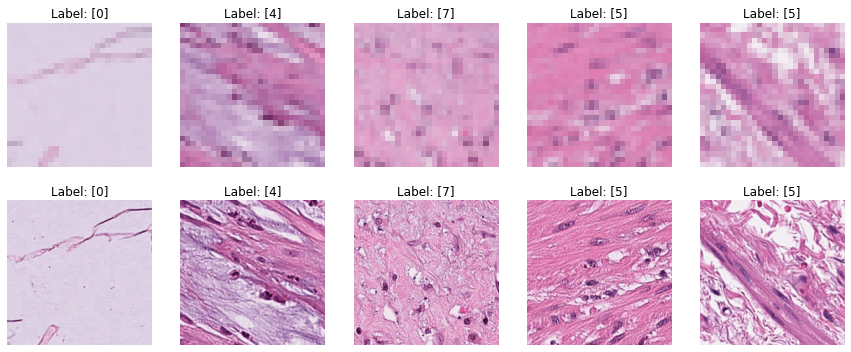

In [37]:
data_dir = 'data/train' 

# transform = transforms.Compose([
#         transforms.ToTensor(),  # Convert PIL images to tensors.
#         transforms.Normalize((0.5,), (0.5,))  # Normalize images.
#     ])

dataset_small = PathMNIST(split='train', root=data_dir, download=False, size=28)
dataset_large = PathMNIST(split='train', root=data_dir, download=False, size=224)
datasets = [dataset_small, dataset_large]
fig, axes = plt.subplots(2, 5, figsize=(15, 6)) # 1 row, 5 columns
for j, row in enumerate(axes):
	for i, ax in enumerate(row):
		# Get the i-th image and its label
		img, label = datasets[j][i]  # img is a PIL image, label is an integer
		ax.imshow(np.array(img), cmap='gray')  # Convert the PIL image to a numpy array
		ax.set_title(f'Label: {label}')
		ax.axis('off')  # Hide the axes
plt.savefig("low_high_res_images", dpi=300)

In [51]:
transform = transforms.Compose([
        transforms.ToTensor(),  # Convert PIL images to tensors.
        transforms.Normalize((0.5,), (0.5,))  # Normalize images.
    ])

dataset_small = PathMNIST(split='train', root=data_dir, download=False, size=28, transform=transform)
dataset_large = PathMNIST(split='train', root=data_dir, download=False, size=224, transform=transform)

In [50]:
# Define a simple SENet block
class SENetBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SENetBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

In [59]:
class SENetBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SENetBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()  # Output attention values
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        # Get attention values
        y = self.avg_pool(x).view(b, c)  # Pool across spatial dimensions
        attention = self.fc(y).view(b, c, 1, 1)  # Compute attention values
        # Recalibrate the input image
        output = x * attention  # Element-wise multiplication
        return output, attention  # Return both output and attention

c:\Users\1Lars\anaconda3\lib\site-packages\torch\nn\init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


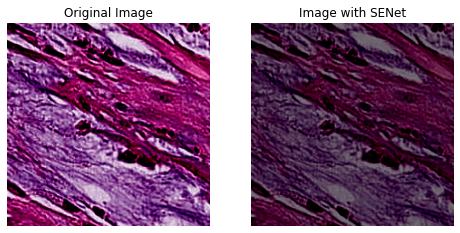

In [56]:
# Convert to batch format for SENet
img1, label = dataset_large[1]
image_batch1 = img1.unsqueeze(0)  # Add a batch dimension

# Apply the SENet block
channels = img1.shape[0]
se_net = SENetBlock(channels)
image_with_se = se_net(image_batch1)

# Plot the original and SENet-processed images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(img1.permute(1, 2, 0))
ax1.set_title("Original Image")
ax2.imshow(image_with_se.squeeze().permute(1, 2, 0).detach().numpy())
ax2.set_title("Image with SENet")
ax1.axis('off')
ax2.axis('off')
plt.savefig("224x224_SEnet", dpi=300)

(-0.5, 27.5, 27.5, -0.5)

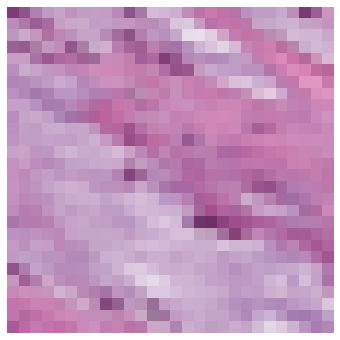

In [47]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
img, label = dataset_small[1]

axes.imshow(np.array(img), cmap='gray')
axes.axis('off')

Text(0.5, 1.0, 'LeNet 28x28 Training')

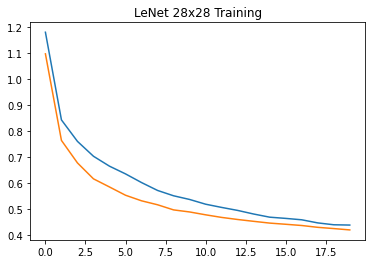

In [58]:
df1 = pd.read_csv("cvs/output_LeNet_28x28_SE_training_data.csv")
df2 = pd.read_csv("cvs/output_LeNet_28x28_training_data.csv")

plt.plot(df1['epoch'], df1['train_loss'], label='with SENet')
plt.plot(df2['epoch'], df2['train_loss'], label='without SENet')
plt.title("LeNet 28x28 Training")

c:\Users\1Lars\anaconda3\lib\site-packages\torch\nn\init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


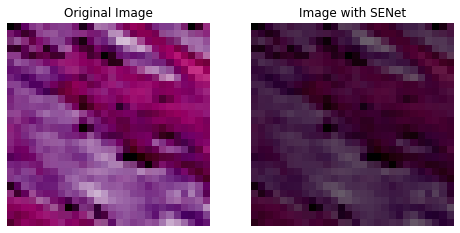

In [60]:
# Convert to batch format for SENet
img1, label = dataset_small[1]
image_batch1 = img1.unsqueeze(0)  # Add a batch dimension

# Apply the SENet block
channels = img1.shape[0]
se_net = SENetBlock(channels)
image_with_se, attention_values  = se_net(image_batch1)

# Plot the original and SENet-processed images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(img1.permute(1, 2, 0))
ax1.set_title("Original Image")
ax2.imshow(image_with_se.squeeze().permute(1, 2, 0).detach().numpy())
ax2.set_title("Image with SENet")
ax1.axis('off')
ax2.axis('off')
plt.savefig("224x224_SEnet", dpi=300)

In [61]:
attention_values

tensor([[[[0.5000]],

         [[0.5000]],

         [[0.5000]]]], grad_fn=<ViewBackward0>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


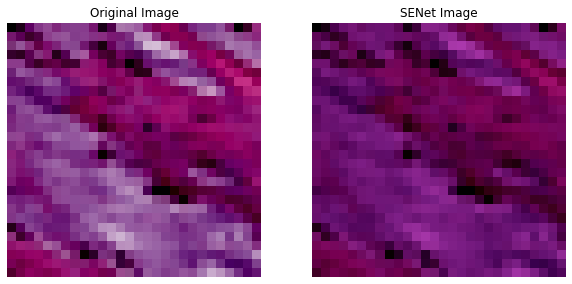

In [75]:
image, label = dataset_small[1]

# Define channel multipliers (adjust these to control channel intensity)
red_multiplier = 0.8  # Red channel adjustment
green_multiplier = 0.3  # Green channel adjustment
blue_multiplier = 0.8  # Blue channel adjustment

# Modify the image by multiplying each color channel by a specific value
modified_image = image.clone()  # Clone the original image
if modified_image.shape[0] == 3:  # If the image has RGB channels
    modified_image[0] *= red_multiplier  # Red channel
    modified_image[1] *= green_multiplier  # Green channel
    modified_image[2] *= blue_multiplier  # Blue channel

# Plot the original and modified images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(image.permute(1, 2, 0))  # Display original image
ax1.set_title("Original Image")

ax2.imshow(modified_image.permute(1, 2, 0))  # Display modified image
ax2.set_title("SENet Image")

ax1.axis('off')
ax2.axis('off')

plt.savefig("small_image_SE_net_.8_.3_.8_RGB.png", dpi=300)